In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

## Train Step

In [2]:
def make_train_step(model, loss_fn, optimizer):
    def perform_train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return perform_train_step

In [3]:
%%writefile model_v1.py
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.1
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(1, 1)).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss(reduction='mean')
train_step = make_train_step(model, loss_fn, optimizer)

Overwriting model_v1.py


In [4]:
%%writefile train_v1.py
n_epochs = 1000
losses = []
for epoch in range(n_epochs):
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)

Overwriting train_v1.py


In [5]:
%run -i datagen.py
%run -i datapre_v0.py
%run -i model_v1.py
%run -i train_v1.py

In [6]:
print(model.state_dict())

OrderedDict({'0.weight': tensor([[1.9690]], device='cuda:0'), '0.bias': tensor([1.0235], device='cuda:0')})


## Dataset

In [7]:
# Implement __init__, __getitem__, __len__
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# No to(device), save RAM in GPU
x_train_tensor = torch.as_tensor(x_train).float()
y_train_tensor = torch.as_tensor(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


In [8]:
# Pytorch TesnorDataset
train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


## DataLoader

In [9]:
%%writefile datapre_v1.py
x_train_tensor = torch.as_tensor(x_train).float()
y_train_tensor = torch.as_tensor(y_train).float()
train_data = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

Overwriting datapre_v1.py


In [10]:
%%writefile train_v2.py
n_epochs = 1000
losses = []
for epoch in range(n_epochs):
    mini_batch_losses = []
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        mini_batch_loss = train_step(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)
    loss = np.mean(mini_batch_losses)
    losses.append(loss)

Overwriting train_v2.py


In [11]:
%run -i datagen.py
%run -i datapre_v1.py
%run -i model_v1.py
%run -i train_v2.py
print(model.state_dict())

OrderedDict({'0.weight': tensor([[1.9696]], device='cuda:0'), '0.bias': tensor([1.0243], device='cuda:0')})


## Mini-Batch

In [12]:
def mini_batch(device, data_loader, step):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        mini_batch_loss = step(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)
    loss = np.mean(mini_batch_losses)
    return loss

In [13]:
%%writefile train_v3.py
n_epochs = 200
losses = []
for epoch in range(n_epochs):
    loss = mini_batch(device, train_loader, train_step)
    losses.append(loss)

Overwriting train_v3.py


In [14]:
%run -i datagen.py
%run -i datapre_v1.py
%run -i model_v1.py
%run -i train_v3.py
print(model.state_dict())

OrderedDict({'0.weight': tensor([[1.9684]], device='cuda:0'), '0.bias': tensor([1.0219], device='cuda:0')})


## Random Split

In [15]:
%%writefile datapre_v2.py
torch.manual_seed(13)
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()
dataset = TensorDataset(x_tensor, y_tensor)
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train
train_data, val_data = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

Overwriting datapre_v2.py


In [16]:
def make_val_step(model, loss_fn):
    def perform_val_step(x, y):
        model.eval()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        return loss.item()
    return perform_val_step

In [17]:
%%writefile model_v2.py
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.1
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(1, 1)).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss(reduction='mean')
train_step = make_train_step(model, loss_fn, optimizer)
val_step = make_val_step(model, loss_fn)

Overwriting model_v2.py


In [18]:
%%writefile train_v4.py
n_epochs = 200
losses = []
val_losses = []
for epoch in range(n_epochs):
    loss = mini_batch(device, train_loader, train_step)
    losses.append(loss)
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step)
        val_losses.append(val_loss)

Overwriting train_v4.py


In [19]:
%run -i datagen.py
%run -i datapre_v2.py
%run -i model_v2.py
%run -i train_v4.py
print(model.state_dict())

OrderedDict({'0.weight': tensor([[1.9438]], device='cuda:0'), '0.bias': tensor([1.0287], device='cuda:0')})


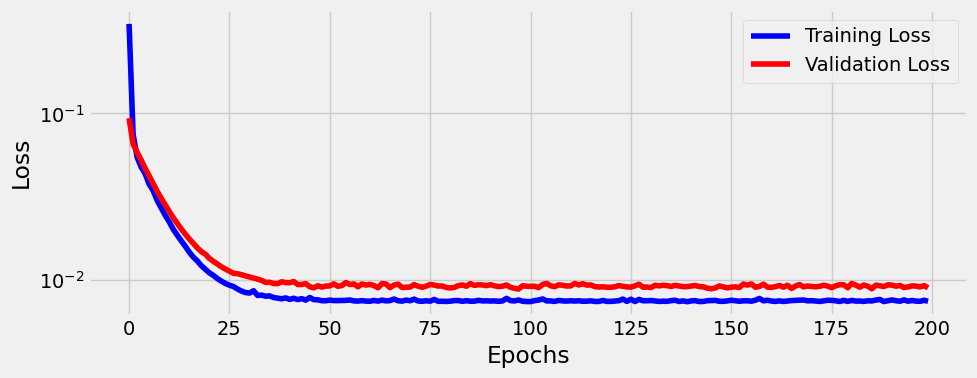

In [20]:
fig = plt.figure(figsize=(10, 4))
plt.plot(losses, label='Training Loss', c='b')
plt.plot(val_losses, label='Validation Loss', c='r')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

## TensorBoard

In [21]:
writer = SummaryWriter('runs/test')
dummy_x, dummy_y = next(iter(train_loader))
writer.add_graph(model, dummy_x.to(device))
writer.add_scalars(main_tag='loss', tag_scalar_dict={'training': loss, 'validation': val_loss}, global_step=epoch)

In [22]:
%load_ext tensorboard

In [23]:
%tensorboard --logdir runs

In [24]:
%%writefile model_v3.py
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.1
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(1, 1)).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss(reduction='mean')
train_step = make_train_step(model, loss_fn, optimizer)
val_step = make_val_step(model, loss_fn)
writer = SummaryWriter('runs/simple_linear_regression')
x_dummy, y_dummy = next(iter(train_loader))
writer.add_graph(model, x_dummy.to(device))

Overwriting model_v3.py


In [25]:
%%writefile train_v5.py
n_epochs = 200
losses = []
val_losses = []
for epoch in range(n_epochs):
    loss = mini_batch(device, train_loader, train_step)
    losses.append(loss)
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step)
        val_losses.append(val_loss)
    writer.add_scalars(main_tag='loss', tag_scalar_dict={'training': loss, 'validation': val_loss}, global_step=epoch)
writer.close()

Overwriting train_v5.py


In [26]:
%run -i datagen.py
%run -i datapre_v2.py
%run -i model_v3.py
%run -i train_v5.py
print(model.state_dict())

<Figure size 640x480 with 0 Axes>

OrderedDict({'0.weight': tensor([[1.9432]], device='cuda:0'), '0.bias': tensor([1.0263], device='cuda:0')})


In [27]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 41830), started 0:00:03 ago. (Use '!kill 41830' to kill it.)

## Save and Load Model

In [28]:
%run -i datagen.py
%run -i datapre_v2.py
%run -i model_v3.py
%run -i train_v5.py
print(model.state_dict())

OrderedDict({'0.weight': tensor([[1.9432]], device='cuda:0'), '0.bias': tensor([1.0263], device='cuda:0')})


In [29]:
checkpoint = {'epoch': n_epochs,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': losses,
              'val_loss': val_losses}
torch.save(checkpoint, 'model_checkpoint.pth')

In [30]:
checkpoint = torch.load('model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
saved_epoch = checkpoint['epoch']
saved_losses = checkpoint['loss']
saved_val_losses = checkpoint['val_loss']
print(model.train())  # Important: make it a habit
print(model.state_dict())

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)
OrderedDict({'0.weight': tensor([[1.9432]], device='cuda:0'), '0.bias': tensor([1.0263], device='cuda:0')})


/tmp/ipykernel_41666/246406728.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_checkpoint.pth')


In [31]:
%run -i train_v5.py
print(model.state_dict())

OrderedDict({'0.weight': tensor([[1.9411]], device='cuda:0'), '0.bias': tensor([1.0230], device='cuda:0')})


In [32]:
print(model.state_dict())

OrderedDict({'0.weight': tensor([[1.9411]], device='cuda:0'), '0.bias': tensor([1.0230], device='cuda:0')})


In [33]:
def plot_resumed_losses(saved_epoch, saved_losses, saved_val_losses, n_epochs, losses, val_losses):
    range_before = range(0, saved_epoch)
    range_after = range(saved_epoch, saved_epoch + n_epochs)
    fig = plt.figure(figsize=(10, 4))
    plt.plot(range_before, saved_losses, label='Checkpointed Training Loss', c='b', linestyle='--')
    plt.plot(range_before, saved_val_losses,  label='Checkpointed Validation Loss', c='r', linestyle='--')
    plt.plot(range_after, losses, label='Training Loss', c='b')
    plt.plot(range_after, val_losses, label='Validation Loss', c='r')
    plt.plot([saved_epoch, saved_epoch], [np.min(saved_losses + losses), np.max(saved_losses + losses)], c='k', linewidth=1, linestyle='--', label='Checkpoint')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig

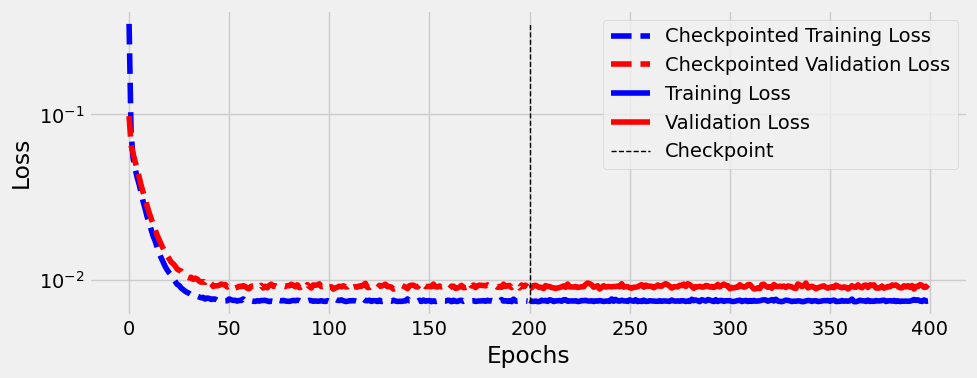

In [34]:
fig = plot_resumed_losses(saved_epoch, saved_losses, saved_val_losses, n_epochs, losses, val_losses)

## Deploy

In [35]:
%run -i model_v3.py
checkpoint = torch.load('model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(model.state_dict())

OrderedDict({'0.weight': tensor([[1.9432]], device='cuda:0'), '0.bias': tensor([1.0263], device='cuda:0')})


/tmp/ipykernel_41666/1307038923.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_checkpoint.pth')


<Figure size 640x480 with 0 Axes>

In [36]:
new_inputs = torch.tensor([[.20], [.34], [.57]])
model.eval()  # Remember it!
print(model(new_inputs.to(device)))

tensor([[1.4150],
        [1.6870],
        [2.1340]], device='cuda:0', grad_fn=<AddmmBackward0>)
